c:\Python312\Lib\site-packages\gym\envs\box2d\lunar_lander.py:604: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(
c:\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\Asus-Rog\AppData\Local\Temp\ipykernel_25908\1949093557.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  states = torch.tensor(self.states, dtype=torch.float)


Episode: 100 - Total Reward: -106.91584569598966
Episode: 200 - Total Reward: -138.8653899115855
Episode: 300 - Total Reward: -112.49903208650007
Episode: 400 - Total Reward: -241.4979483097196
Episode: 500 - Total Reward: -35.83624973541228
Episode: 600 - Total Reward: -16.666391811045173
Episode: 700 - Total Reward: 28.922687670615762
Episode: 800 - Total Reward: -84.60520163944516
Episode: 900 - Total Reward: -57.61084699549025
Episode: 1000 - Total Reward: -67.24171948326067


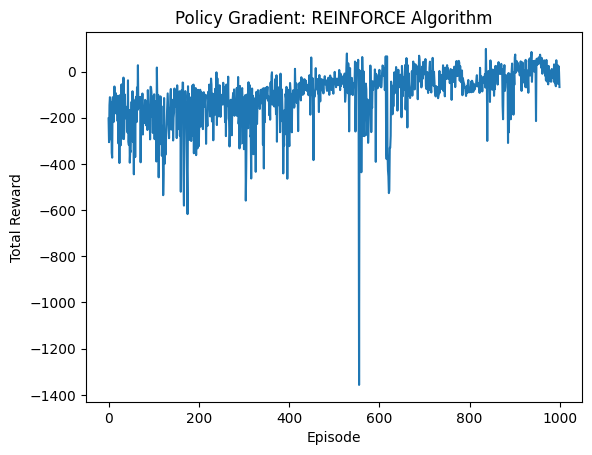

In [9]:
#ascenso por el gradiente
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
#El agente de política de gradiente es un algoritmo de aprendizaje por refuerzo que aprende una política óptima directamente desde la experiencia, sin necesidad de una función de valor.
#se crea una red neuronal que toma el estado actual del entorno y predice la probabilidad de cada acción posible.
class PolicyGradientAgent:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.state_size = 8
        self.action_size = 4
        self.gamma = 0.99
        
        self.model = self._build_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        self.states = []
        self.actions = []
        self.rewards = []

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.action_size),
            nn.Softmax(dim=-1)
        )
        return model
    
    def remember(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probabilities = self.model(state)
        action = torch.multinomial(probabilities, num_samples=1).item()
        return action
    
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        cumulative = 0
        for t in reversed(range(len(rewards))):
            cumulative = cumulative * self.gamma + rewards[t]
            discounted_rewards[t] = cumulative
        return discounted_rewards
    
    def train(self):
        discounted_rewards = self.discount_rewards(self.rewards)
        
        states = torch.tensor(self.states, dtype=torch.float)
        actions = torch.tensor(self.actions, dtype=torch.int64)
        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float)
        
        logits = self.model(states)
        action_probabilities = logits.gather(1, actions.unsqueeze(1)).squeeze()
        
        loss = -torch.log(action_probabilities) * discounted_rewards
        loss = loss.mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.states, self.actions, self.rewards = [], [], []

def train(episodes, render_freq=100):
    env = gym.make("LunarLander-v2")
    agent = PolicyGradientAgent()
    
    rewards_per_episode = []
    
    for i in range(episodes):
        if (i+1) % 100 == 0:
            env = gym.make("LunarLander-v2", render_mode="human")
        else:
            env = gym.make("LunarLander-v2")
        state = env.reset()[0]
        episode_rewards = 0
        done = False

        # Renderiza al inicio de cada 100 episodios
        if i % render_freq == 0:
            env.render()
        
        while not done:
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.remember(state, action, reward)
            state = next_state
            episode_rewards += reward
            done = terminated or truncated
            
        agent.train()
        rewards_per_episode.append(episode_rewards)
        
        if (i+1) % 100 == 0:
            print(f"Episode: {i+1} - Total Reward: {episode_rewards}")
            
    env.close()
    
    plt.plot(rewards_per_episode)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Policy Gradient: REINFORCE Algorithm')
    plt.show()

if __name__ == "__main__":
    train(1000)